<a href="https://colab.research.google.com/github/MattLeRoi/new_project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank

Dataset information -
The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact with the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:

9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means 
client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17 - y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: None

In [1]:
# !pip install lightgbm
# !pip install catboost
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier, Pool, cv

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
df=pd.read_csv('bank-full.csv', delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


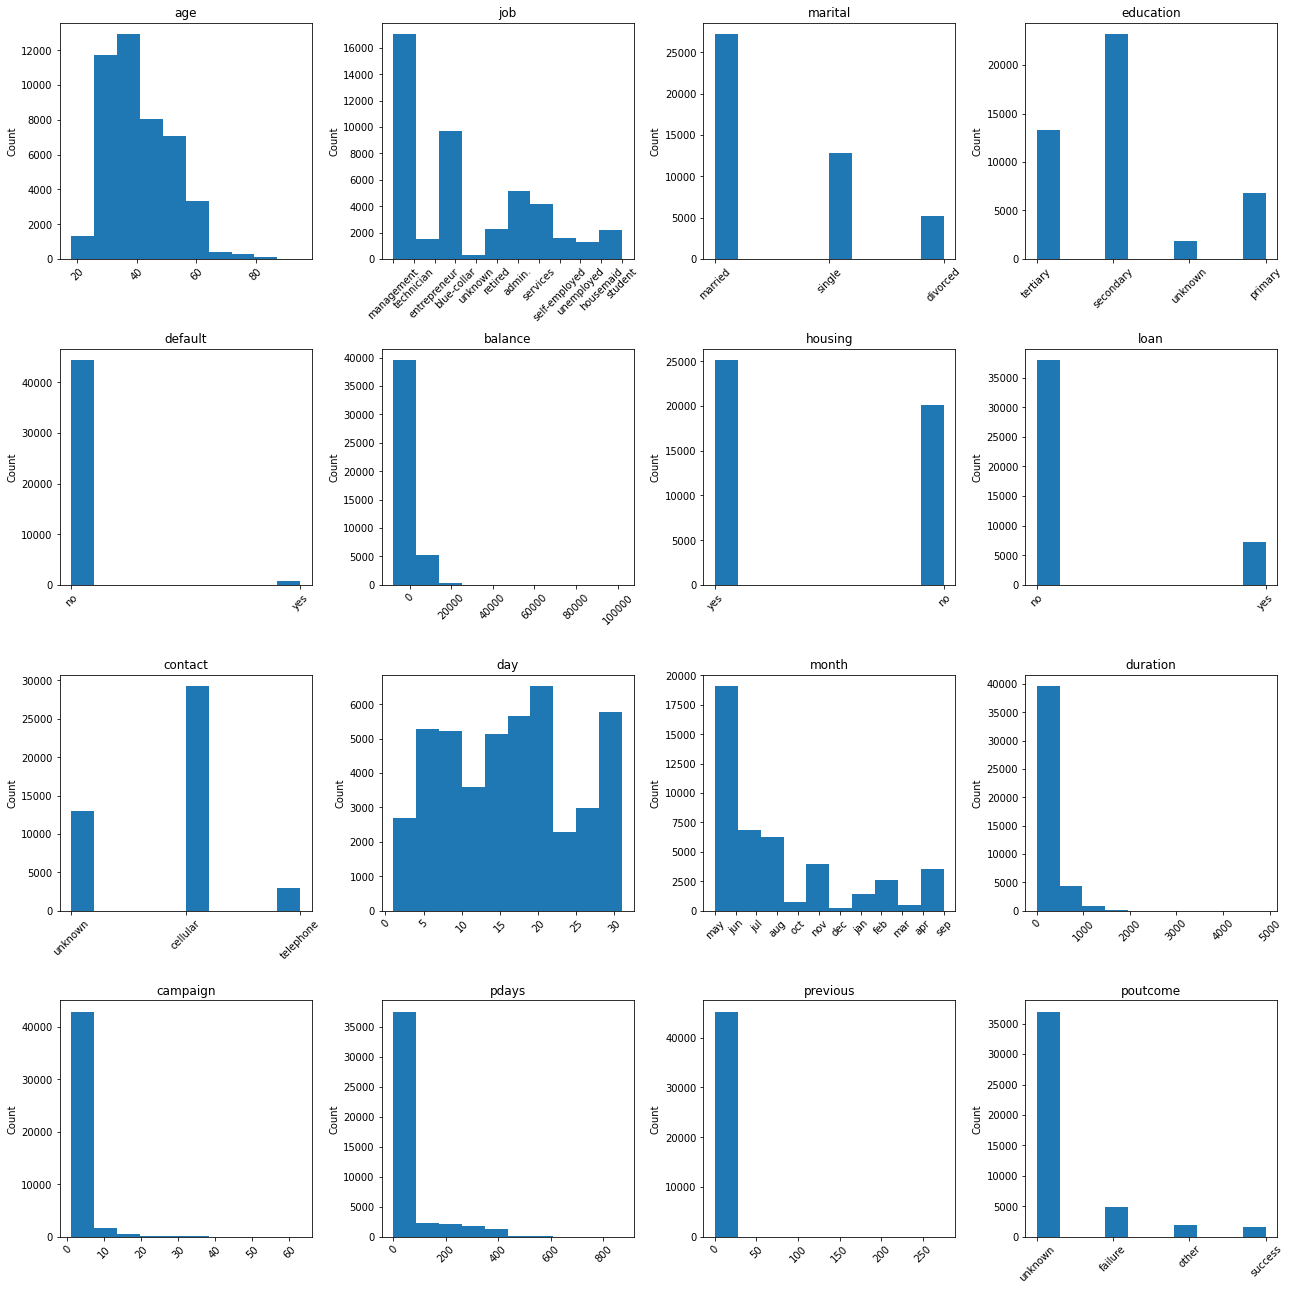

In [4]:
# Display histograms and counts of people per category
i=1
fig, axes = plt.subplots(4,4, figsize=(18,18))
for col in df.drop('y', axis=1).columns:
    plt.subplot(4,4,i)
    plt.title(col)
    plt.hist(df[col])
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.tight_layout(pad=1.0);
    i+=1

In [5]:
# Calculate the percentage of people that signed
y_n_counts = df.y.value_counts()
print("Overall percent signed:",round(y_n_counts[1]/sum(y_n_counts)*100,2),'%')

Overall percent signed: 11.7 %


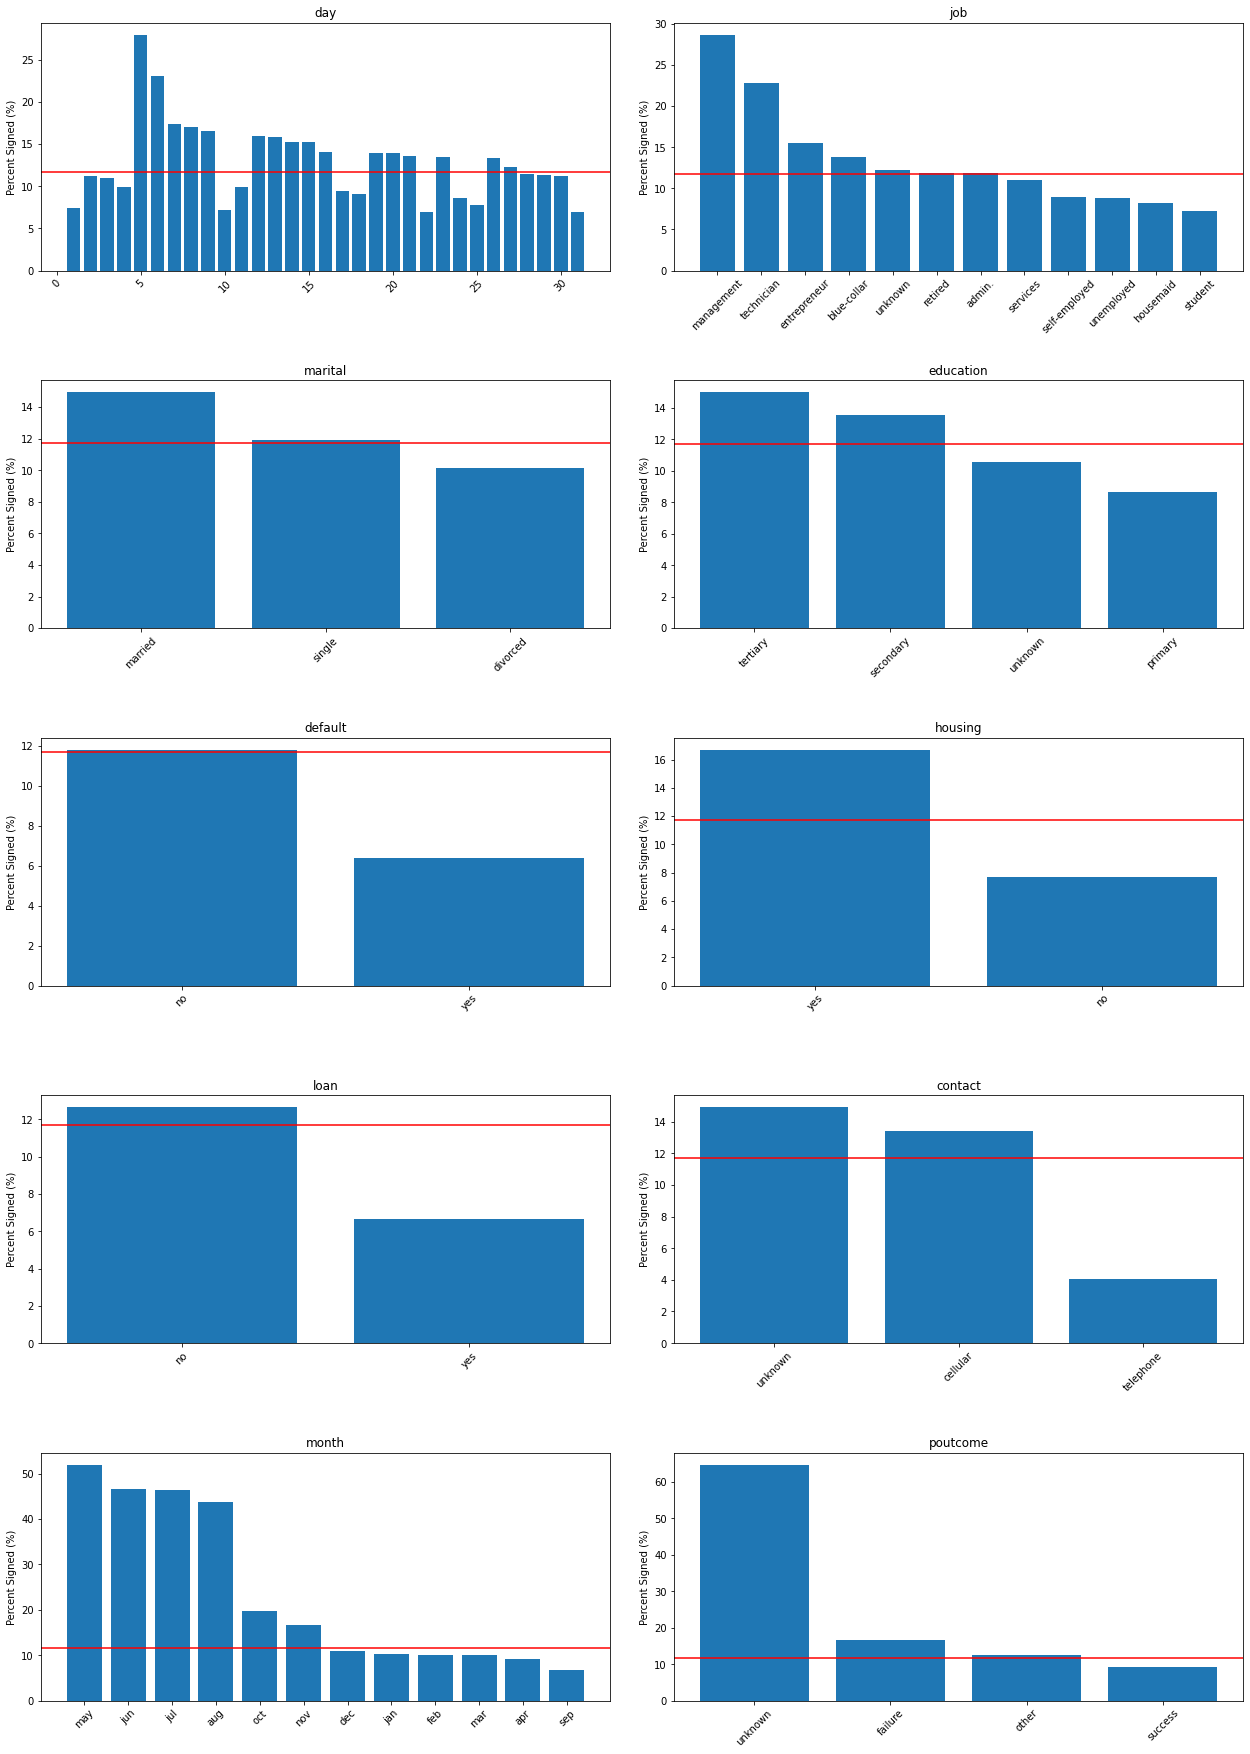

In [6]:
# Create bar charts with % signed for each column

categorical_features = ['day','job','marital','education','default','housing','loan','contact','month','poutcome']
temp_y = []
i=1
fig, axes = plt.subplots(5,2, figsize=(18,25))
for cat in categorical_features:
    temp_x = df[cat].unique()
    temp_y = df.groupby(cat)['y'].apply(lambda x: (x == 'yes').mean() * 100).sort_values(ascending=False)
    plt.subplot(5,2,i)
    plt.bar(temp_x, temp_y)
    plt.title(cat)
    plt.xticks(rotation=45)
    plt.ylabel('Percent Signed (%)')
    plt.axhline(y=11.7, color='r')
    plt.tight_layout(pad=3.0);
    i+=1

In [7]:
X=df.drop(['y','pdays'], axis=1) # The -1 in pdays throws off the math. previous also functions as a flag for previously contacted
y = [1 if target_y_n == "yes" else 0 for target_y_n in df['y']]

In [8]:
X_encoded = pd.get_dummies(X, columns=categorical_features) # checking if drop_first makes a difference

,age,balance,duration,campaign,previous,day_1,day_2,day_3,day_4,day_5,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,261,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,44,29,151,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,33,2,76,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
3,47,1506,92,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
4,33,1,198,1,0,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,977,3,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
45207,71,1729,456,2,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
45208,72,5715,1127,5,3,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
45209,57,668,508,4,0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [9]:
# Creating test, validation, and training sets

X_all_training,X_test_raw,y_all_training,y_test = train_test_split(X_encoded,y,random_state=42, test_size=.15) # 15% test set
X_train_raw,X_val_raw,y_train,y_val = train_test_split(X_all_training,y_all_training,random_state=42, test_size=.1/.85) # 10% validation set

In [10]:
# Scale each column. Fit on the training set, then transform val and test sets.
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_encoded.columns)
X_val = pd.DataFrame(scaler.transform(X_val_raw), columns=X_encoded.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=X_encoded.columns)

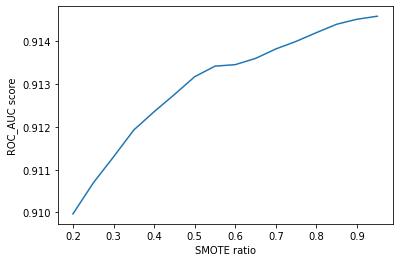

Wall time: 9.55 s


In [11]:
%%time
# This will loop through a range of ratios to feed into the SMOTE function to analyze the effect of oversampling the 
# churning customers to improve the sensitivity of the model. The results are plotted to visualize the optimum value.

ratios = np.arange(.2,1,.05)
ROC_AUC_smote = []

for ratio in ratios:
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

    logreg_resample = LogisticRegression(random_state=42)
    logreg_resample.fit(X_train_resampled, y_train_resampled)
    y_proba = logreg_resample.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    ROC_AUC_smote.append(score)
    
fig, ax = plt.subplots()
ax.plot(ratios,ROC_AUC_smote,label='ROC_AUC score')
ax.set_ylabel('ROC_AUC score')
ax.set_xlabel('SMOTE ratio')
plt.show();

In [12]:
# Making the final smote version the one that runs through the rest of the code

# X_train = X_train_resampled
# y_train = y_train_resampled

w/o smoting:

Model	Score
0	LogisticRegression(random_state=42)	0.911404
1	(DecisionTreeClassifier(max_features='sqrt', r...	0.926134
2	XGBClassifier(base_score=None, booster=None, c...	0.931322
3	LGBMClassifier(random_state=42, verbose=0)	0.933431
4	<catboost.core.CatBoostClassifier object at 0x...	0.934607


In [13]:
roc_results = pd.DataFrame(columns=['Model','Score'])
imp_factors = pd.DataFrame()#columns=['LogisticRegression','DecisionTreeClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier'])
def add_score (roc_results,model_name,model_title):
    y_proba = model_name.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    print("ROC-AUC:", score,'\n')
    new_row_data = {'Model':model_title, 'Score':score}
    roc_results.loc[len(roc_results)] = new_row_data
    return roc_results

In [14]:
# Update with the ones i'm using 
log_reg = LogisticRegression(random_state=42)
rf=RandomForestClassifier(random_state=42)
xgb_model=XGBClassifier(random_state=42)
lgbm_model=LGBMClassifier(random_state=42,verbose=0)
cat_boost=CatBoostClassifier(random_state=42,verbose=0)

models = [('log_reg', log_reg),('rf', rf),('xgb_model', xgb_model),('lgbm_model', lgbm_model),('cat_boost', cat_boost)]

for title, model in models:
    print(title)
    model.fit(X_train,y_train)
    add_score(roc_results, model, title)
#     print('\n')

log_reg
ROC-AUC: 0.9114035913672226 

rf
ROC-AUC: 0.9261335326357748 

xgb_model
ROC-AUC: 0.9313220656834935 

lgbm_model
ROC-AUC: 0.933431317161588 

cat_boost
ROC-AUC: 0.9346073192644642 



log_reg
ROC-AUC: 0.9133975966008734 

rf
ROC-AUC: 0.922561879877123 

xgb_model
ROC-AUC: 0.9305609500606147 

lgbm_model
ROC-AUC: 0.93087064369196 

cat_boost
ROC-AUC: 0.9340158853461703 

### Logistic Regression

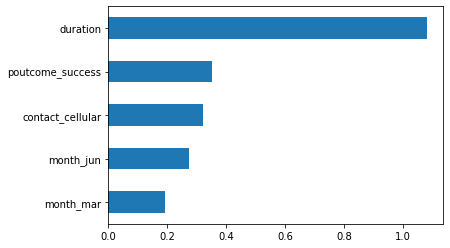

In [15]:
coefs = pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False).head(5).sort_values(ascending=True)
coefs.plot(kind='barh');
imp_factors['LogisticRegression']=coefs.sort_values(ascending=False).head(5).index

### Random Forest

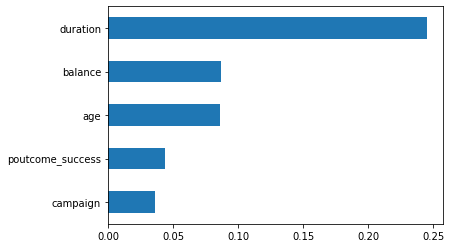

In [16]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(5).sort_values(ascending=True).plot(kind='barh');
imp_factors['RandomForestClassifier']=importances.sort_values(ascending=False).head(5).index

### XGBoost

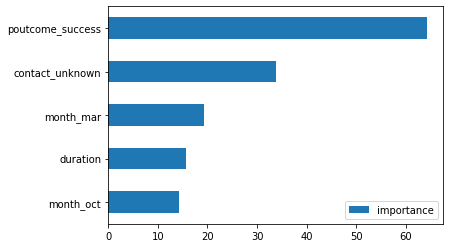

In [17]:
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'importance':list(importance.values())}, index=importance.keys())

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['XGBClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

### Light GBM

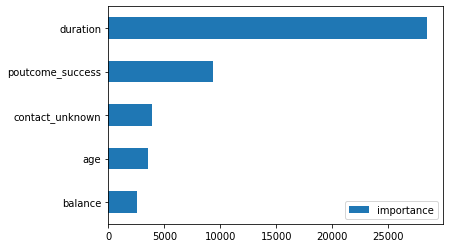

In [18]:
importance = lgbm_model.booster_.feature_importance(importance_type='gain')
feature_names = lgbm_model.feature_name_

importance_df = pd.DataFrame({'importance':importance}, index=feature_names)

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['LGBMClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

### Cat Boost

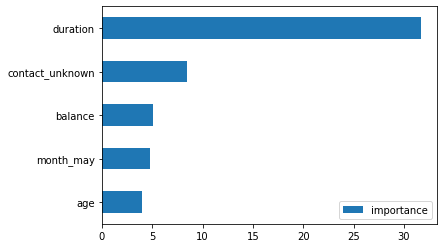

In [19]:
importance = cat_boost.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({'importance':importance}, index=feature_names)

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['CatBoostClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

In [20]:
imp_factors

,LogisticRegression,RandomForestClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier
0,duration,duration,poutcome_success,duration,duration
1,poutcome_success,balance,contact_unknown,poutcome_success,contact_unknown
2,contact_cellular,age,month_mar,contact_unknown,balance
3,month_jun,poutcome_success,duration,age,month_may
4,month_mar,campaign,month_oct,balance,age


In [21]:
factor_importance_results = pd.DataFrame(columns=['score'], index=X_train.columns)

for cat in X_train.columns:
    tot_factor_weight=0
    for col in imp_factors:
        ind_factor_weight = 5-imp_factors[imp_factors[col].str.contains(cat, case=False, na=False)].index
        if ind_factor_weight > 0:
            tot_factor_weight += ind_factor_weight
    if tot_factor_weight > 0:
        factor_importance_results.at[cat, 'score'] = tot_factor_weight[0]
    else: factor_importance_results.at[cat, 'score'] = 0

factor_importance_results.sort_values(by='score', ascending=False).head(5)

,score
duration,22
poutcome_success,15
contact_unknown,11
balance,8
age,6


In [22]:
%%time

from itertools import product

depths = [6,8,10] # was 6,8,10
learning_rates = [0.03, .05, .07] # was .03, .05, .07
l2_leaf_regs = [1,3] # was 1,3

train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

results = []

for lr, d, l2 in product(learning_rates, depths, l2_leaf_regs):
    model = CatBoostClassifier(
        learning_rate=lr,
        depth=d,
        l2_leaf_reg=l2,
        iterations=1000,
        early_stopping_rounds=50,
        use_best_model=True,
        verbose=False,
        random_seed=42
    )
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
    y_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)
    results.append((d, lr, l2, score))

results_df = pd.DataFrame(results, columns=['depth', 'learning_rate', 'l2_leaf_reg', 'AUC'])
results_df=results_df.sort_values('AUC', ascending=False)
display(results_df)

,depth,learning_rate,l2_leaf_reg,AUC
11,10,0.05,3,0.935661
15,8,0.07,3,0.935641
2,8,0.03,1,0.935600
17,10,0.07,3,0.935569
3,8,0.03,3,0.935477
9,8,0.05,3,0.935430
5,10,0.03,3,0.934961
8,8,0.05,1,0.934939
7,6,0.05,3,0.934778
0,6,0.03,1,0.934735


Wall time: 1min 56s


In [23]:
%%time
# results_df.sort_values('AUC', ascending=False, inplace=True)
best_params = {
    'depth': results_df['depth'].iloc[0],
    'learning_rate': results_df['learning_rate'].iloc[0],
    'iterations': 1000,
    'l2_leaf_reg': results_df['l2_leaf_reg'].iloc[0],
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'use_best_model': True,
    'verbose': False
}

final_model = CatBoostClassifier(**best_params);
final_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0);

Wall time: 9.69 s


In [24]:
best_params

{'depth': 10,
 'learning_rate': 0.05,
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'random_seed': 42,
 'early_stopping_rounds': 50,
 'use_best_model': True,
 'verbose': False}

In [25]:
add_score(roc_results,final_model,'final_model1')

ROC-AUC: 0.9356607189796342 



,Model,Score
0,log_reg,0.911404
1,rf,0.926134
2,xgb_model,0.931322
3,lgbm_model,0.933431
4,cat_boost,0.934607
5,final_model1,0.935661


In [26]:
%%time
for model_name in [log_reg,rf,xgb_model,lgbm_model,cat_boost, final_model]:
    y_pred = model_name.predict(X_test)
    y_proba = model_name.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_proba)
    print(model_name," ROC-AUC:", score)

LogisticRegression(random_state=42)  ROC-AUC: 0.9065378204652159
RandomForestClassifier(random_state=42)  ROC-AUC: 0.9210541624378048
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)  ROC-AUC: 0.9296948618296739
LGBMClassifier(random_state=42, verbose=0)  ROC-AUC: 0.9306987523826026
<catboost.core.

In [27]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print('Accuracy:',round(accuracy_score(y_test,y_pred)*100,2),'%')
print(confusion_matrix(y_test,y_pred))
print(roc_auc_score(y_test,y_proba))


Accuracy: 90.78 %
[[5753  217]
 [ 408  404]]
0.9320789084998062


look at two sets - previously contacted vs not? 
check number of each

make plot of % yes for each category